In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('Kwadella_winter_2013_cleaned.csv')
print df.head()


   Unnamed: 0  Dusttraks_(mg/m3)  PM10_(ug/m3)  PM2.5_(ug/m3)  SO2_(ppb)  \
0         120                NaN           NaN            NaN        NaN   
1         121                NaN           NaN            NaN        NaN   
2         122                NaN           NaN            NaN        NaN   
3         123                NaN           NaN            NaN        NaN   
4         124                NaN           NaN            NaN        NaN   

   CO_(ppm)  NO_(ppb)  NO2_(ppb)          Date  Temperature_(degC)   ...     \
0       NaN       NaN        NaN  7/2/13 14:00                 NaN   ...      
1       NaN       NaN        NaN  7/2/13 14:01                 NaN   ...      
2       NaN       NaN        NaN  7/2/13 14:02                 NaN   ...      
3       NaN       NaN        NaN  7/2/13 14:03                 NaN   ...      
4       NaN       NaN        NaN  7/2/13 14:04                 NaN   ...      

   H05-K-N  H06-K-N  H07-K-S  H10-K-N  H11-K-X  H12-K-N  H15-K-S  H1

Some things to note with the winter 2013 cleaned dataset: 

1) the outdoor temperature data starts on 7/4/13/ 13:10, which is about two days after the data for temperature indoors actually starts 

In [4]:
from datetime import datetime
def get_datetime(s):
    dt = datetime.strptime(s, "%m/%d/%y %H:%M")
    return dt

def preprocess(df):
    res = df.copy()
    datetimes = res.Date.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Day'] = datetimes.apply(lambda dt: dt.day)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Year'] = datetimes.apply(lambda dt: dt.year)
    return res

def daysSinceStart(df):
    #get time since epoch
    dayArray = np.array(df.Day)
    monthArray = np.array(df.Month)
    
    runningDays = []
    for day, month in zip(dayArray, monthArray):
        if month == 7:
            total_days = 0
        elif month == 8:
            total_days = 31 
        elif month == 9:
            total_days = 61
        else:
            raise ValueError 
        total_days = total_days + day
        runningDays.append(total_days)
    df['DayCount'] = pd.Series(runningDays, index = df.index)
    return df

In [5]:
df = preprocess(df)
df = daysSinceStart(df)

In [6]:
print df.head()

   Unnamed: 0  Dusttraks_(mg/m3)  PM10_(ug/m3)  PM2.5_(ug/m3)  SO2_(ppb)  \
0         120                NaN           NaN            NaN        NaN   
1         121                NaN           NaN            NaN        NaN   
2         122                NaN           NaN            NaN        NaN   
3         123                NaN           NaN            NaN        NaN   
4         124                NaN           NaN            NaN        NaN   

   CO_(ppm)  NO_(ppb)  NO2_(ppb)          Date  Temperature_(degC)    ...     \
0       NaN       NaN        NaN  7/2/13 14:00                 NaN    ...      
1       NaN       NaN        NaN  7/2/13 14:01                 NaN    ...      
2       NaN       NaN        NaN  7/2/13 14:02                 NaN    ...      
3       NaN       NaN        NaN  7/2/13 14:03                 NaN    ...      
4       NaN       NaN        NaN  7/2/13 14:04                 NaN    ...      

   H12-K-N  H15-K-S  H17-K-N  H18-K-S  H20-K-S  Hour  Day  Mon

In [7]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
import numpy as np
import pprint as pp
from IPython.display import display

/home/mackenzie/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/mackenzie/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


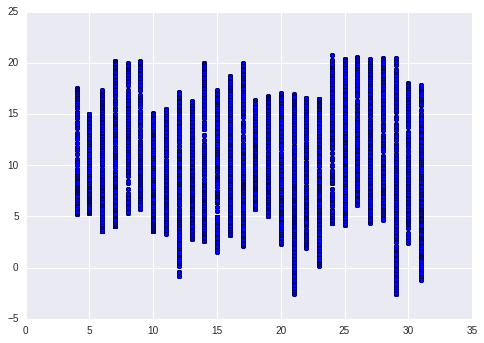

In [8]:
dfjuly = df[df['Month'] ==7]

plt.scatter(dfjuly['Day'], dfjuly['Temperature_(degC)'] )

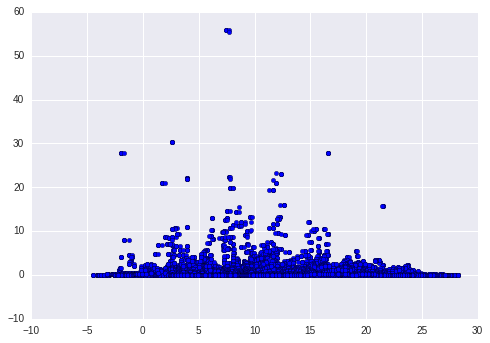

In [9]:
plt.scatter(df['Temperature_(degC)'], df['Dusttraks_(mg/m3)'])

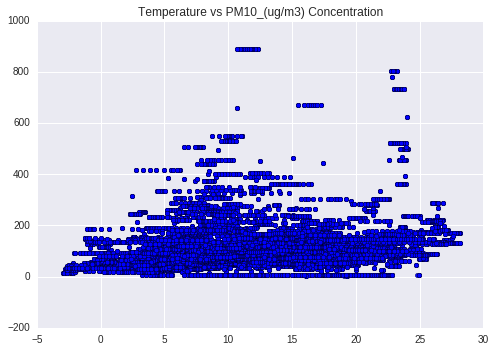

In [10]:
def scatter_temp_particles(df, dusttraks):
    plt.scatter(df['Temperature_(degC)'], df[dusttraks])
    plt.title('Temperature vs ' + dusttraks + ' Concentration' )
    
scatter_temp_particles(df, 'PM10_(ug/m3)')


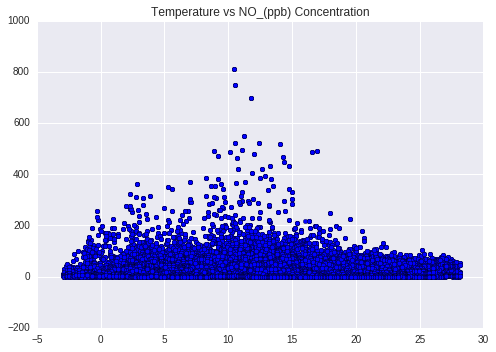

In [11]:
scatter_temp_particles(df, 'PM2.5_(ug/m3)')
scatter_temp_particles(df, 'SO2_(ppb)')
scatter_temp_particles(df, 'NO_(ppb)')
                       

So none of these scatter plots are particularly helpful. I'm going to take the Days since epoch, or the days count column I created earlier, to graph trends over the course of the year. I think I want to start with just taking the average indoor temperature for each day to find days where, overall, the oven is used more indoors. I'm hoping there will be a definite day where the indoor temp goes up and stays up for a while, showing that's when the oven is left on. 

Next I need to find an average for all te homes with a kitchen temperature sensor

In [12]:
#Removed: df['H07-K-S'].mean()
import matplotlib.pyplot as plt
def compute_avg_val(df):
    df['AvgHouse'] = (df['H01-K-E'].mean()+ df['H02-K-N'].mean() + df['H03-K-S'].mean()+ df['H04-K-S'].mean()
                      + df['H05-K-N'].mean()+df['H06-K-N'].mean() + df['H10-K-N'].mean()
                      +df['H11-K-X'].mean()+ df['H12-K-N'].mean() + df['H15-K-S'].mean() +df['H17-K-N'].mean() 
                      + df['H18-K-S'].mean() + df['H20-K-S'].mean()
                      )/13
    return df

def plot_by_days(df,header):
    grouped = df.groupby(header)
    df = grouped.apply(compute_avg_val)
    plt.plot(df[header],df.AvgHouse, linewidth=0, marker='o', markersize=5, alpha=.75)
    plt.legend('house 1')
    plt.xlabel('Days Since Study Started')
    plt.ylabel('Temperature in C')
    plt.title('Average temperature in a timeframe')
    plt.show()

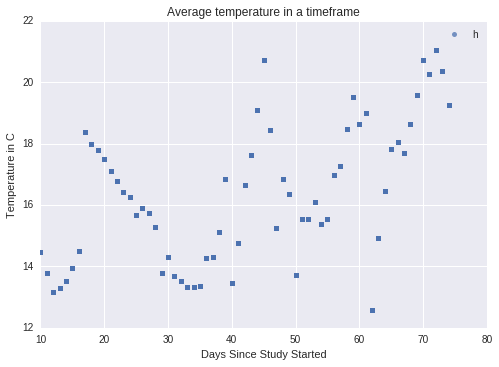

In [13]:
plot_by_days(df,'DayCount')

Now I'm diving the winter into 3 distinct chunks based on month. My hope here is that I'll be able to compare different averages and look for a key point when pollution/burning increases

In [14]:
julydf = df[df['Month']==7]
augustdf = df[df['Month']== 8]
sepdf = df[df['Month']==9]

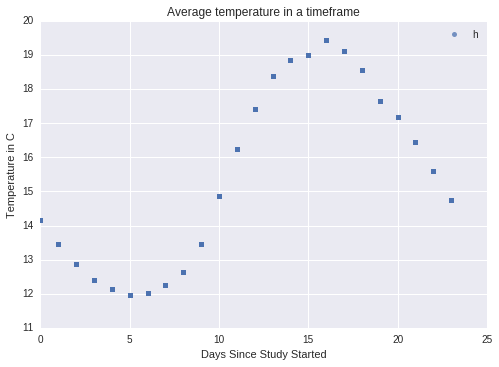

In [15]:
plot_by_days(julydf, 'Hour')
#julydf.Hour.value_counts()

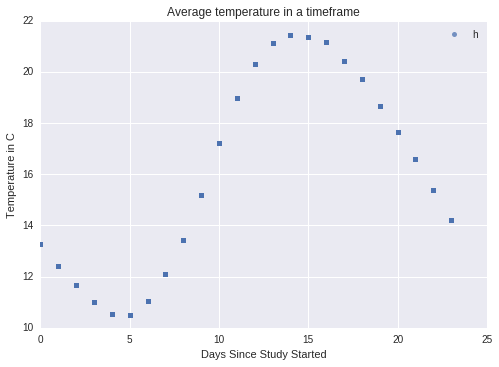

In [16]:
plot_by_days(augustdf, 'Hour')

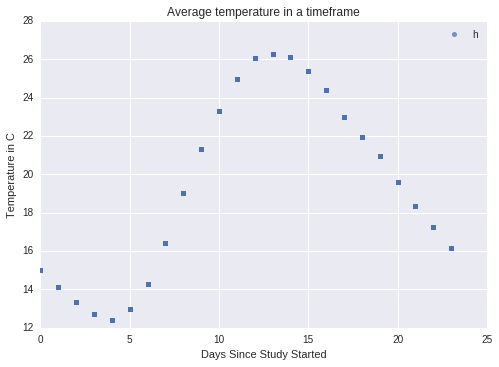

In [17]:
plot_by_days(sepdf, 'Hour')

In [18]:
# this plot is actually the one we want to look at, comparing the three months
def plot_all_months(df,df2,df3,header):
    grouped = df.groupby(header)
    df = grouped.apply(compute_avg_val)
    
    grouped2 = df2.groupby(header)
    df2 = grouped2.apply(compute_avg_val)
    
    grouped3 = df3.groupby(header)
    df3 = grouped3.apply(compute_avg_val)

    plt.plot(df[header],df.AvgHouse, 'r', df2[header], df2.AvgHouse, 'b', df3[header],df3.AvgHouse, 'g', linewidth=0, marker='o', markersize=5, alpha=.75)
    plt.legend(['july', 'aug', 'sep'])
    plt.xlabel('Hour in the Day')
    plt.ylabel('Temperature in C')
    plt.title('Average temperature in one month')
    plt.show()
    

As the winter progresses, days indoors become much warmer! I'm next going to compare this to the outdoor temperature values. I definitely need to look at eliminating these gross horizontal lines

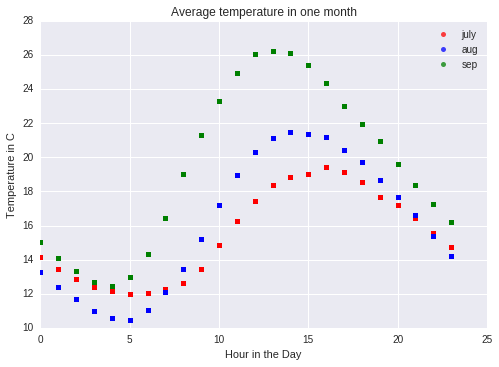

In [19]:
plot_all_months(julydf, augustdf, sepdf, 'Hour')

In [20]:
def compute_avg_temp(df):
    df['AvgTemp'] = df['Temperature_(degC)'].mean()
    return df

def plot_all_months(df,df2,df3,header1,header2):
    
    grouped = df.groupby(header1)
    df = grouped.apply(compute_avg_temp)
    
    grouped2 = df2.groupby(header1)
    df2 = grouped2.apply(compute_avg_temp)
    
    grouped3 = df3.groupby(header1)
    df3 = grouped3.apply(compute_avg_temp)
    
    plt.plot(df[header1],df[header2], 'r', label ='july')
    plt.plot(df2[header1], df2[header2], 'b',label = 'aug') 
    plt.plot(df3[header1],df3[header2], 'g', label = 'sep')
    plt.legend()
    plt.xlabel('Hour in the day')
    plt.ylabel('Temperature in C')
    plt.title('Average temperature in one month')
    plt.show()

In [28]:
def getmeanfeatureforhour (hourdf, feature):
    res = hourdf[feature].mean()
    return res
def featurehourplot(df, feature, title):
    #feature for example could be a temperature or pollutant concentration
    dfhour0 = df[df['Hour'] == 0]
    feat0 = getmeanfeatureforhour(dfhour0, feature)
    dfhour1 = df[df['Hour'] == 1]
    feat1= getmeanfeatureforhour(dfhour1, feature)
    dfhour2 = df[df['Hour'] == 2]
    feat2 = getmeanfeatureforhour(dfhour2, feature)
    dfhour3 = df[df['Hour'] == 3]
    feat3 = getmeanfeatureforhour(dfhour3, feature)
    dfhour4 = df[df['Hour'] == 4]
    feat4 = getmeanfeatureforhour(dfhour4, feature)
    dfhour5 = df[df['Hour'] == 5]
    feat5 = getmeanfeatureforhour(dfhour5, feature)
    dfhour6 = df[df['Hour'] == 6]
    feat6 = getmeanfeatureforhour(dfhour6, feature)
    dfhour7 = df[df['Hour'] == 7]
    feat7 = getmeanfeatureforhour(dfhour7, feature)
    dfhour8 = df[df['Hour'] == 8]
    feat8 = getmeanfeatureforhour(dfhour8, feature)
    dfhour9 = df[df['Hour'] == 9]
    feat9 = getmeanfeatureforhour(dfhour9, feature)
    dfhour10 = df[df['Hour'] == 10]
    feat10 = getmeanfeatureforhour(dfhour10, feature)
    dfhour11 = df[df['Hour'] == 11]
    feat11 = getmeanfeatureforhour(dfhour11, feature)
    dfhour12 = df[df['Hour'] == 12]
    feat12 = getmeanfeatureforhour(dfhour12, feature)
    dfhour13 = df[df['Hour'] == 13]
    feat13 = getmeanfeatureforhour(dfhour13, feature)
    dfhour14 = df[df['Hour'] == 14]
    feat14 = getmeanfeatureforhour(dfhour14, feature)
    dfhour15 = df[df['Hour'] == 15]
    feat15 = getmeanfeatureforhour(dfhour15, feature)
    dfhour16 = df[df['Hour'] == 16]
    feat16 = getmeanfeatureforhour(dfhour16, feature)
    dfhour17 = df[df['Hour'] == 17]
    feat17 = getmeanfeatureforhour(dfhour17, feature)
    dfhour18 = df[df['Hour'] == 18]
    feat18 = getmeanfeatureforhour(dfhour18, feature)
    dfhour19 = df[df['Hour'] == 19]
    feat19 = getmeanfeatureforhour(dfhour19, feature)
    dfhour20 = df[df['Hour'] == 20]
    feat20 = getmeanfeatureforhour(dfhour20, feature)
    dfhour21 = df[df['Hour'] == 21]
    feat21 = getmeanfeatureforhour(dfhour21, feature)
    dfhour22 = df[df['Hour'] == 22]
    feat22 = getmeanfeatureforhour(dfhour22, feature)
    dfhour23 = df[df['Hour'] == 23]
    feat23 = getmeanfeatureforhour(dfhour23, feature)

    hourlist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    featlist = [feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23]
    plt.plot(hourlist, featlist, label=title)
    plt.legend
    plt.xlabel('Hour')
    if feature[0:1] == 'H0':
        plt.ylabel('Temp, Degrees C')
    else:
        plt.ylabel(feature)
    plt.title(title)
    
def compute_avg_val(df):
    df['AvgHouse'] = (df['H01-K-E'].mean()+ df['H02-K-N'].mean() + df['H03-K-S'].mean()+ df['H04-K-S'].mean()
                      + df['H05-K-N'].mean()+df['H06-K-N'].mean() + df['H10-K-N'].mean()
                      +df['H11-K-X'].mean()+ df['H12-K-N'].mean() + df['H15-K-S'].mean() +df['H17-K-N'].mean() 
                      + df['H18-K-S'].mean() + df['H20-K-S'].mean()
                      )/13
    return df

def plot_by_days(df,header):
    grouped = df.groupby(header)
    df = grouped.apply(compute_avg_val)

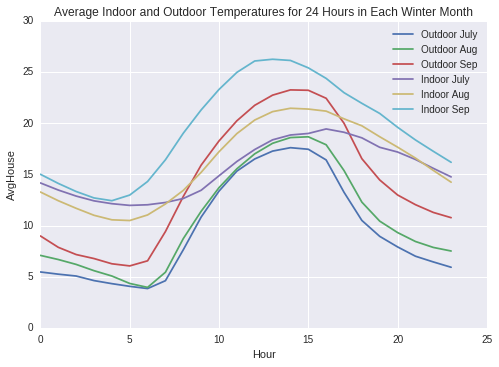

In [35]:
grouped = julydf.groupby('Hour')
julydf = grouped.apply(compute_avg_val)

grouped = augustdf.groupby('Hour')
augustdf = grouped.apply(compute_avg_val)

grouped = sepdf.groupby('Hour')
sepdf = grouped.apply(compute_avg_val)

featurehourplot(julydf, 'Temperature_(degC)', 'Average Outdoor Temperature over Each Hour of Day')
featurehourplot(augustdf, 'Temperature_(degC)', 'Average Outdoor Temperature over Each Hour of Day')
featurehourplot(sepdf, 'Temperature_(degC)', 'Average Outdoor Temperature over Each Hour of Day')
featurehourplot(julydf, 'AvgHouse', 'Average Outdoor Temperature over Each Hour of Day')
featurehourplot(augustdf, 'AvgHouse', 'Average Outdoor Temperature over Each Hour of Day')
featurehourplot(sepdf, 'AvgHouse', 'Average Outdoor Temperature over Each Hour of Day')

plt.legend(['Outdoor July','Outdoor Aug','Outdoor Sep','Indoor July','Indoor Aug','Indoor Sep'])
plt.title('Average Indoor and Outdoor Temperatures for 24 Hours in Each Winter Month')
